In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
  print("Please install GPU version of TF")

if tf.config.list_physical_devices('TPU'):
  print('TPU is available')
else:
  print('TPU is not available')

Default GPU Device: /device:GPU:0
TPU is not available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Object Detection using TensorFlow and Pascal VOC 2007 Dataset

In this exercise, we will adapt our image classification task to an object detection task. Object detection involves not only classifying objects within an image but also localizing them with bounding boxes.

Note: Due to the limited computational resources available, we'll be using a smaller subset of the Pascal VOC 2007 dataset and a lightweight object detection model. This might result in lower accuracy, but the focus of this exercise is on understanding the concepts and workflow of object detection.

## Steps:
1. Install (if necessary) and Import the libraries you will need for this project
2. Load the Pascal VOC 2007 dataset
3. Use a pre-trained object detection model (SSD MobileNet V2)
4. Display detected objects with bounding boxes
    

In [ ]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib


In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1



### Load the VOC2007 dataset

We will use the VOC2007 dataset, which contains images with annotations for object detection. For demonstration purposes, we will load a small subset of the dataset using TensorFlow Datasets.

- VOC2007 is a dataset for object detection, segmentation, and image classification.
- We define a function load_data to load the COCO dataset.
- tfds.load is a function that downloads and prepares the dataset.
- We use only 1% of the training data to keep the demonstration manageable.
- shuffle_files=True ensures that we get a random sample of the dataset.
- with_info=True returns additional information about the dataset, which we'll use later.

- The PASCAL VOC2007 (Visual Object Classes) dataset is a widely used benchmark dataset for object recognition tasks in computer vision. It comprises a collection of images annotated with bounding boxes and class labels for objects belonging to 20 different categories.

Key characteristics of the VOC2007 dataset:

- Purpose: Primarily used for training and evaluating object detection algorithms, but also applicable to other tasks like image classification and semantic segmentation.
- Object Categories: Includes a diverse set of 20 object classes, ranging from people and animals to vehicles and indoor items.
- Data Format: The dataset provides images along with corresponding annotation files containing bounding box coordinates and class labels for each object in the image.
- Image Variety: Features a wide range of images captured in diverse real-world scenarios, offering realistic challenges for object recognition models.
- Benchmark: Serves as a standard benchmark for comparing the performance of different object detection algorithms, fostering progress in the field.

Common use cases of the VOC2007 dataset:
- Training: Used as training data to teach object detection models to identify and localize objects within images.
- Evaluation: Employed to evaluate the performance of trained models by comparing their predictions against the ground truth annotations.
- Research: Utilized in research to develop and test new object detection algorithms and techniques.

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:10%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('validation[:10%]')

# Get class names
class_names = train_info.features["objects"]["label"].names  # Changed from ds_info to train_info
print("Class names:", class_names)



Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


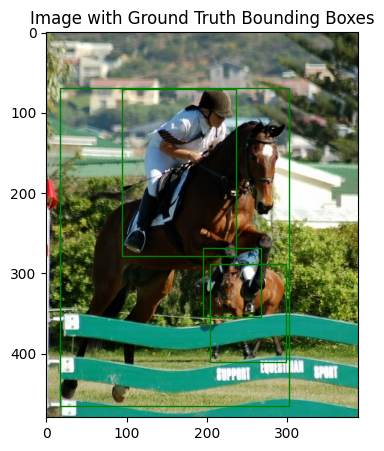

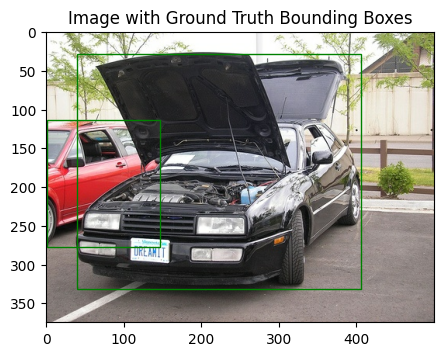

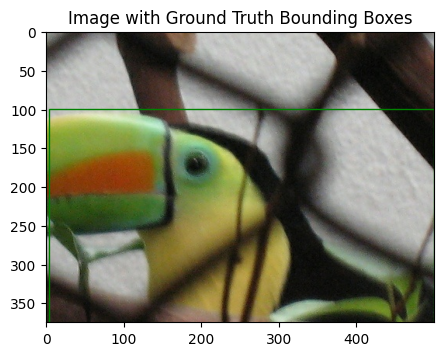

In [ ]:
def display_examples(dataset, n=3):  # Display 'n' examples by default
    for example in dataset.take(n):
        image = example["image"]
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title("Image with Ground Truth Bounding Boxes")

        # Draw ground truth boxes
        for box in example["objects"]["bbox"]:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)

        plt.show()

display_examples(train_dataset)



### Find Images with Specific Classes

We got  the list of all class names in the VOC2007 dataset and select images containing our target classes (e.g., person, car, bird).

- `class_names` provides the list of class names.
- `target_class_ids` contains the IDs of the classes we are interested in.
- `find_images_with_classes` is a function to find images containing our target classes.


### When To Load the model
Loading the model early (right after dataset loading):

Pros: Model is immediately available; clear separation of setup and processing.
Cons: Potentially inefficient if data prep is extensive or fails.


Loading the model after data preparation:

Pros: More efficient resource use; avoids unnecessary loading if data prep fails.
Cons: Model isn't available for any data prep steps that might need it.


In our specific case, loading the model after data preparation is slightly better because:

Our data prep doesn't need the model.
It's more resource-efficient.
It follows a logical flow: prepare data, load tools, process data.
It avoids unnecessary model loading if data prep fails.

However, the difference is minimal in this small-scale example. For beginners, loading major components upfront can sometimes be clearer and easier to follow.
As a best practice, aim to load your model as close as possible to where you'll use it, ensuring all necessary data and resources are ready first.

In [ ]:
#Load a pre-trained object detection model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

Let's break this down:

- 1. hub.load(): This function is from TensorFlow Hub (tensorflow_hub). It downloads and loads models from the TensorFlow Hub repository.
- 2. "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2": This is the URL of the specific model we're loading. It's an SSD (Single Shot Detector) MobileNet V2 model, which is efficient for object detection tasks.
- 3. Detector: The loaded model is assigned to this variable. It becomes a callable object that you can use for object detection.

Advantages of this approach:

Concise and readable
Directly loads the model without additional wrapper functions
TensorFlow Hub handles caching, so subsequent loads will be faster

### Display Detected Objects with Bounding Boxes

We will use the pre-trained model to detect objects in our selected images and display them with bounding boxes.

- `detector` is the pre-trained object detection model.
- `detect_objects` is a function that uses the model to detect objects in an image.
- `display_detections` is a function to display the detected objects with bounding boxes.



### Helper Function to Display Bounding Boxes on Images

The `display_image_with_boxes` function takes an image, bounding boxes, and class names, then displays the image with bounding boxes drawn around detected objects.
- run_detector: This function prepares an image and runs it through our object detection model.
- plot_detections: This function visualizes the detected objects by drawing bounding boxes and labels on the image.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

In [ ]:
# Run Detector and Visualize
def run_detector_and_visualize(example):
    image = example["image"]
    ground_truth_boxes = example["objects"]["bbox"]

    # Preprocess and run detection
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Visualize results (with ground truth for comparison)
    plt.figure(figsize=(10, 7))
    plt.imshow(image)

    # Ground truth boxes (VOC format is [xmin, ymin, xmax, ymax])
    for box in ground_truth_boxes:
        ymin, xmin, ymax, xmax = box
        rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                linewidth=1, edgecolor='g', facecolor='none', label='Ground Truth')
        plt.gca().add_patch(rect)

    # Predicted boxes
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:  # Confidence threshold
            ymin, xmin, ymax, xmax = result['detection_boxes'][0][i]
            class_id = int(result['detection_classes'][0][i])

            # Handle invalid class IDs (classes outside the VOC dataset)
            if class_id < len(class_names):
                label = class_names[class_id]

            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
            plt.gca().add_patch(rect)

            # Moved plt.text to the correct loop for the predicted box
            plt.text(xmin * image.shape[1], ymin * image.shape[0] - 5, f'{label}: {score:.2f}', color='white', backgroundcolor='r')

    plt.legend()
    plt.show()







###   Process and Display Images with Detections
The `detect_and_display` function runs object detection on an image and displays the results, as you saw above. The function converts the image to the appropriate format, runs the detector, and then uses the helper function to display the results.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

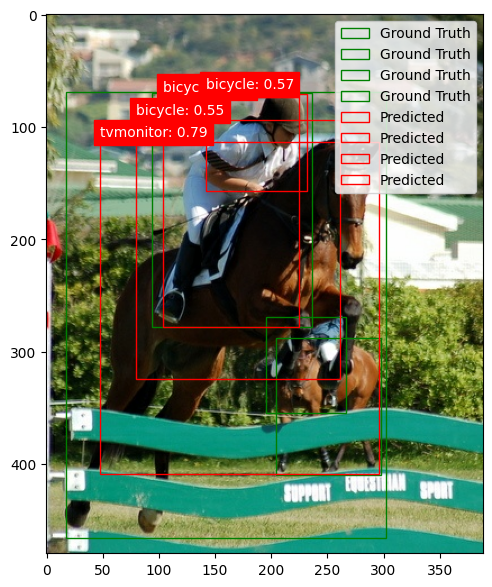

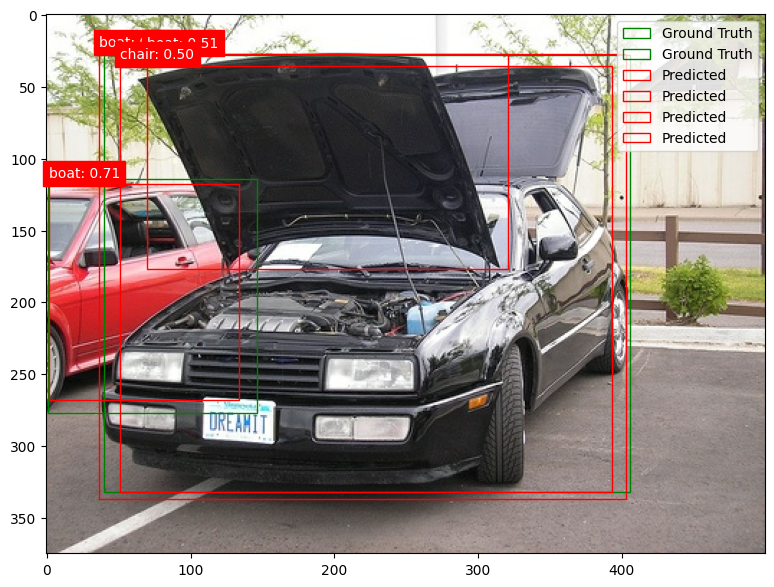

In [ ]:
# take a few examples from the training set
for example in train_dataset.take(2):  # Process 2 images
    run_detector_and_visualize(example)



#### Your Turn
Process a few images from the dataset
print("\nProcessing sample images from the dataset:") for i, example in enumerate(train_dataset.take(3)): print(f"\nSample image {i+1}") image = example['image'].numpy() detections = run_detector(detector, image) plot_detections(image, detections, class_names)

## Mode Evaluation
###  Define the Evaluation Function

 The function called evaluate_model_performance which evaluates the performance of our object detection model on a dataset. The function takes three arguments: the dataset to evaluate on, the object detection model, and the number of images to use for evaluation. It calculates and prints the accuracy of the model based on the detections.   

In [ ]:
#Evaluate Model Performance
def evaluate_model_performance(dataset, detector, iou_threshold=0.5, num_samples=100):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for example in dataset.take(num_samples):
        image = example["image"].numpy()
        gt_boxes = example["objects"]["bbox"].numpy()
        gt_labels = example["objects"]["label"].numpy()

        # Preprocess and run detection (same as before)
        converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        pred_boxes = result['detection_boxes'][0]
        pred_scores = result['detection_scores'][0]
        pred_labels = result['detection_classes'][0].astype(int)

        # Iterate over predicted boxes
        for i, score in enumerate(pred_scores):
            if score < 0.5:  # Confidence threshold
                continue

            # Convert box coordinates to [ymin, xmin, ymax, xmax]
            pred_box = pred_boxes[i]
            pred_box = [pred_box[1], pred_box[0], pred_box[3], pred_box[2]]

            # Find matching ground truth box (if any) based on IoU
            best_iou = 0
            for j, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    gt_index = j

            # If IoU exceeds threshold, check class match
            if best_iou > iou_threshold:
                if pred_labels[i] == gt_labels[gt_index]:
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                false_positives += 1

        # Count false negatives (missed ground truth boxes)
        false_negatives += len(gt_boxes) - true_positives

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Model Performance (IoU Threshold = {iou_threshold:.2f}):")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# (You'll need to implement a 'calculate_iou' function)
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): Coordinates of the first box in the format [ymin, xmin, ymax, xmax].
        box2 (list): Coordinates of the second box in the same format.

    Returns:
        float: The IoU value (between 0 and 1).
    """

    # 1. Calculate coordinates of the intersection rectangle
    y1 = max(box1[0], box2[0])
    x1 = max(box1[1], box2[1])
    y2 = min(box1[2], box2[2])
    x2 = min(box1[3], box2[3])

    # 2. Calculate areas of the intersection and the union
    intersection_area = max(0, y2 - y1) * max(0, x2 - x1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # 3. Calculate IoU
    if union_area == 0:
        return 0  # Avoid division by zero
    else:
        iou = intersection_area / union_area
        return iou

# Evaluate model performance
print("Evaluating model performance...")
evaluate_model_performance(validation_dataset, detector)  # Use test data for evaluation


Evaluating model performance...
Model Performance (IoU Threshold = 0.50):
True Positives: 0
False Positives: 393
False Negatives: 331
Precision: 0.00
Recall: 0.00


### Object Detection Evaluation Core Concepts

* Object detection models need to be evaluated on two fronts:

- Classification Accuracy: Did the model correctly identify the object's class (e.g., person, car, bird)?
- Localization Accuracy: Did the model accurately draw a bounding box around the object?

 Our exercise  focuses on assessing localization accuracy using the Intersection over Union (IoU) metric.

* Understanding IoU (Intersection over Union)

IoU measures how much two bounding boxes overlap.

- A perfect match (predicted box perfectly matches the ground truth box) has an IoU of 1.
- No overlap has an IoU of 0.

The iou_threshold in the code (default 0.5) means a predicted box is considered a "true positive" only if its IoU with a ground truth box is 0.5 or higher.

* Output Interpretation:

The function will print the following metrics:

- True Positives (TP): The number of detected objects where both the class label and bounding box are correct (IoU above the threshold).
- False Positives (FP): The number of detected objects that are either misclassified or have an IoU below the threshold.
- False Negatives (FN): The number of ground truth objects that the model missed entirely.
- Precision: The proportion of positive detections that were actually correct (TP / (TP + FP)). A high precision means the model makes few false alarms.
- Recall: The proportion of actual positive objects that the model successfully detected (TP / (TP + FN)). A high recall means the model misses few objects.

Example Results:
Let's say the output is:

Model Performance (IoU Threshold = 0.50):
True Positives: 75
False Positives: 20
False Negatives: 15
Precision: 0.79
Recall: 0.83
Interpretation:

- The model correctly detected and localized 75 objects.
- It made 20 incorrect detections (wrong class or poor box placement).
- It missed 15 objects that were actually present in the images.
- Precision is 0.79, meaning 79% of the model's positive detections were accurate.
- Recall is 0.83, meaning the model found 83% of the actual objects in the images.

* Key Takeaways:
- Precision vs. Recall: There's often a trade-off between these two. Increasing the confidence threshold (e.g., to 0.6) might improve    precision (fewer false alarms) but likely lower recall (more missed objects).
- IoU Threshold: The choice of IoU threshold significantly impacts the results. A higher threshold makes the evaluation stricter, potentially lowering both precision and recall.
- Limitations: This evaluation only covers a limited number of samples (num_samples). For a more comprehensive assessment, you'd ideally use a larger and more diverse evaluation set.
- Single Metric: Precision and recall alone don't tell the whole story. Consider using other metrics like F1 score (harmonic mean of precision and recall) for a more balanced view of performance.








### Upload your Image
This final block allows you to input your own image URL for object detection, making the exercise interactive.


 ### Instructions  to Upload Your Own Images

In [ ]:
import os

# Define the directory path
images_dir = "images"

# Create the directory if it doesn't exist
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
    print(f"Directory '{images_dir}' created.")
else:
    print(f"Directory '{images_dir}' already exists.")


Directory 'images' created.


Extracted files: []


Saving cats.jpg to cats.jpg
Saving boat.jpg to boat.jpg
Saving horses.jpg to horses.jpg
Saving cars.jpg to cars.jpg
Saving dogs.jpg to dogs.jpg

Processing: cats.jpg


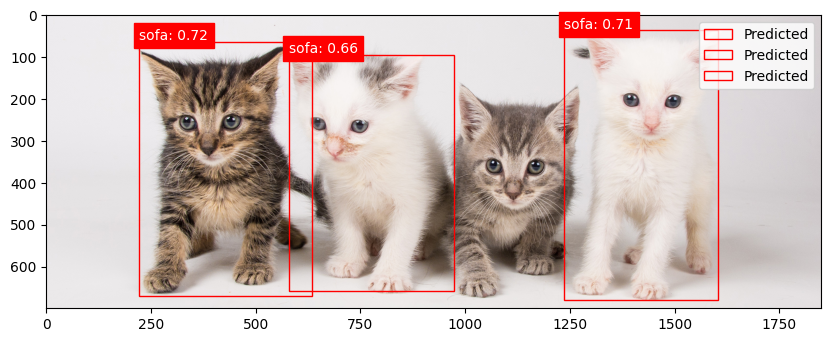


Processing: boat.jpg


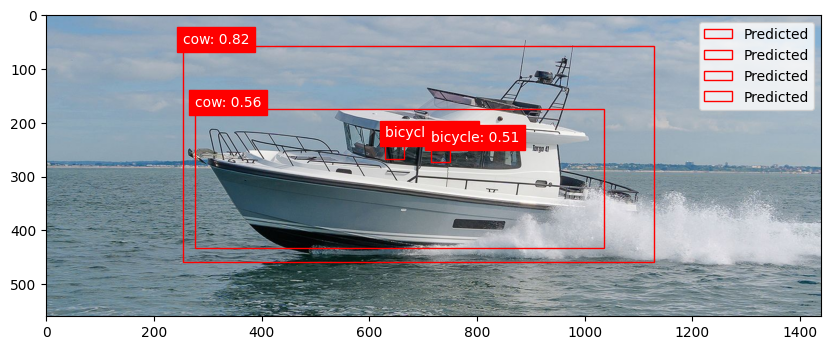


Processing: horses.jpg


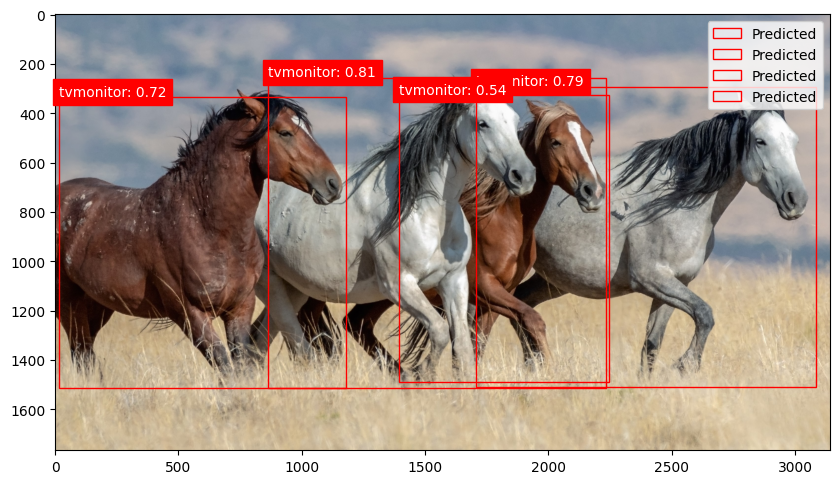


Processing: cars.jpg


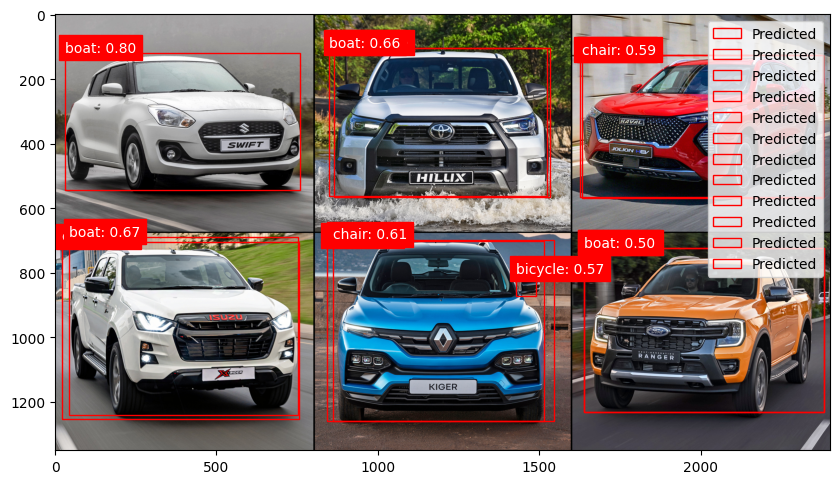


Processing: dogs.jpg


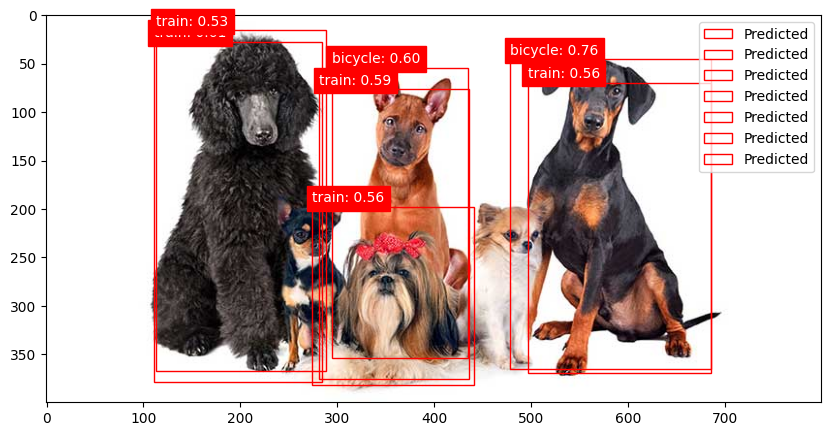


To upload your own image for object detection:
1. If using Google Colab, use:
   from google.colab import files
   uploaded = files.upload()
   image_data = next(iter(uploaded.values()))
2. Then run:
   process_uploaded_image(image_data)


In [ ]:
from google.colab import files
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module

# Check files
print("Extracted files:", os.listdir("images"))
# Function to process uploaded images (for Google Colab)
def process_uploaded_image(image_data):
    """Processes and displays detections for an uploaded image."""
    image = Image.open(BytesIO(image_data))
    image_np = np.array(image)  # Convert PIL Image to NumPy array
    # Use the existing run_detector_and_visualize function
    run_detector_and_visualize({"image": image_np, "objects": {"bbox": [], "label": []}})


# Step 1: Upload image(s) from your computer
uploaded = files.upload()

# Step 2: Process each uploaded image
for filename, image_data in uploaded.items():
    print(f"\nProcessing: {filename}")
    process_uploaded_image(image_data)

# Instructions for image uploading (if in Google Colab)
print("\nTo upload your own image for object detection:")
print("1. If using Google Colab, use:")
print("   from google.colab import files")
print("   uploaded = files.upload()")
print("   image_data = next(iter(uploaded.values()))")
print("2. Then run:")
print("   process_uploaded_image(image_data)")

### Conclusion
This exercise introduces you to object detection while keeping computational requirements relatively low. It uses a pre-trained model, so no training is required, making it suitable for systems with limited resources.

Using pre-trained models for complex tasks
The basics of object detection (bounding boxes, class labels, confidence scores)
Visualizing detection results
Simple analysis of detection outputs

The exercise is also interactive, allowing students to try object detection on their own chosen images. Copy

## Questions for Reflection and Analysis:
1. **Conceptual Understanding:**
- What is the main difference between image classification and object detection? How is this difference evident in the output of this exercise?
Image classification is the process of assigning a single label to the image. Some examples of the class names we saw in our lab are car, bird, boat, bus, aeroplane, horse, etc. Image classification doesn't allow us to identify multiple objects or their location. On the other hand, object detection allows us to classify and locate objects by using bounding boxes and label the images accordingly. When working in this Lab, we can see the difference in the outputs, we can see the multiple bounding boxes around the objects in the images, and how they are labeled with a class.

- Explain why we chose the SSD MobileNet V2 model for this task. What are its advantages and limitations, especially in the context of limited computational resources?
The main reasons we chose the SSD MobileNet V2 model for this Lab are its speed, efficiency, and accuracy. Some of the advantages of this model include its high speed which is suitable for real-time applications, the lower memory and CPU/GPU requirements that make it accessible if high-end hardware isn't available, and the pretrained model accelerates transfer learning. Some of the disadvantages include lower accuracy, the model struggles to detect some objects because the reduced feature extraction capacity, and the bounding boxes are less precise compared to higher-capacity detectors.

2. **Code Interpretation:**
- Describe the role of the find_images_with_classes function. Why is it useful when working with a large dataset like COCO?
The role of the find_images_with_classes function is to find images containing our target classes. In this Lab, we are working with 20 different classes (aeroplane, bicycle, bird, boat, etc), and we are only working with 1% of the training data to keep the demonstration manageable. COCO is a large dataset that contains over 330,000 images and 80 classes, which is the main reason we need to use the find_images_with_classes function, because we need to focus only on the images that contain the classes we are working with to avoid wasting time and resources.

- In the plot_detections function, how does the threshold value (threshold=0.5) impact the number of objects displayed?
The plot_detection function is the one that displays the detected objects with bounding boxes, and the threshold value (threshold = 0.5 in our lab) represents the minimum confidence score required for a predicted box to be considered a "true positive". A true positive is the number of detected objects where both the class label and bounding box were correct. If we increase the threshold, it might increase precision but potentially miss valid objects, and if we lower the threshold, we will include invalid objects.

- Explain how the heatmap visualization helps you understand the model's confidence in its detections.
The heatmap helps me visualize the results of the exercise because it shows me the spatial regions where the model detects objects. Brighter areas indicate higher confidence, while darker areas indicate lower confidence. Heatmaps are a useful tool in object detection it will show us where the model is focusing its attention. By having a visualization, we can work on the model errors and data biases, creating a more accurate and trustworthy model.

3. **Observing Results and Limitations:**
- Run the exercise multiple times. Which types of objects does the model tend to detect more accurately? Which ones are more challenging? Can you explain why?
After running the exercise multiple times, I noticed that the model tends to detect large objects more accurately, objects like bicycle, tvmonitor, chair, and boat, but the model has a hard time detecting small objects like cat, dog, and bird. The reason the model has a hard time detecting smaller objects is that small objects have fewer pixels, some objects may have fewer training examples, and overlapping can make detection more difficult.

- Observe the bounding boxes. Are there any instances where the boxes are inaccurate or miss the object entirely? What factors in the images might be contributing to these errors?
What I observed in this Lab when running the exercise is that the boxes didn't miss the object entirely, but there were some instances where the boxes were inaccurate. Some of the factors that contribute to a box not fitting the object or missing the object entirely include the size of the objects, occlusion, poor-quality images, and class similarity.

- How would you expect the accuracy of the model to change if we had used the entire Pascal VOC 2007 dataset instead of a small subset? Why?
If we use the entire Pascal VOC 2007 dataset, the model accuracy would increase. Having a large dataset gives our model diverse objects that improve generalization. VOC2007 is a benchmark for comparing the performance of different object detection algorithms, making it useful in the development and testing of new detection techniques. In this Lab, we only used a small subset because the focus was on understanding the concepts; if we used the entire dataset, we would need more computation time and memory.

4. **Critical Thinking:**
- How could you modify the code to detect a specific set of objects, like only animals or only vehicles?
I can modify the find_images_with_classes function to only return images containing animals and vehicles. I can also change the detection loop and include a conditional statement that keeps only the classes that are animals and vehicles.

- If you wanted to train your own object detection model, what steps would you need to take? What are some challenges you might encounter?
The steps that I would need to take to train my own object detection model include data collection and annotation, model selection (depending on the model, I need to choose the right architecture), training (transfer learning or from scratch), evaluation, and deployment. Some of the challenges that I would encounter include the requirement of powerful GPUs if I'm using large-scale training, the time and accuracy required for data collection and annotation, overfitting if the data is not adequate, and the challenge to balance precision and inference.

- Given the limitations of this model, in what real-world scenarios might it still be useful for object detection?
The model we are working with is a single-shot detector, and it is efficient for object detection tasks. Due to the efficiency and speed of the model, I think the real-world scenarios that might still be useful include security systems where approximate detection is sufficient, and mobile applications like an app that can identify objects by using the phone's camera.

5. **Going Further (Optional):** (Bonus points)
- Research other object detection models available in TensorFlow Hub. Compare and contrast them with SSD MobileNet V2 in terms of accuracy, speed, and resource requirements.
Some of the available models in TensorFlow Hub include EfficientDet (it's more accurate than MobileNet, but it's also heavier), YOLO (it's extremely fast but not very accurate when it comes to small objects), and Faster R-CNN (it's a high-accuracy model but is slower and resource-heavy).

- Try running a few images through a more powerful object detection model online (if available). Compare the results to the output of this exercise. What differences do you notice?
A powerful object detection model has more accurate bounding boxes that align better to the objects, it also has a higher confidence score, and a high recall. See screenshots below.

- Important: Remember, the goal here isn't perfect accuracy. It's to understand the core concepts of object detection, the limitations of working with restricted resources, and how to critically analyze the results.

**References**

- Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016). SSD: Single Shot MultiBox Detector. In European conference on computer vision (pp. 21–37). Springer. https://arxiv.org/abs/1512.02325
- Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. Proceedings of the IEEE conference on computer vision and pattern recognition, 4510–4520. https://arxiv.org/abs/1801.04381
- Everingham, M., Van Gool, L., Williams, C. K., Winn, J., & Zisserman, A. (2010). The Pascal Visual Object Classes (VOC) Challenge. International journal of computer vision, 88(2), 303–338.
- Redmon, J., & Farhadi, A. (2018). YOLOv3: An Incremental Improvement. arXiv preprint arXiv:1804.02767. https://arxiv.org/abs/1804.02767
- Tan, M., Pang, R., & Le, Q. V. (2020). EfficientDet: Scalable and Efficient Object Detection. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, 10781–10790. https://arxiv.org/abs/1911.09070

## Online object detector model output ##

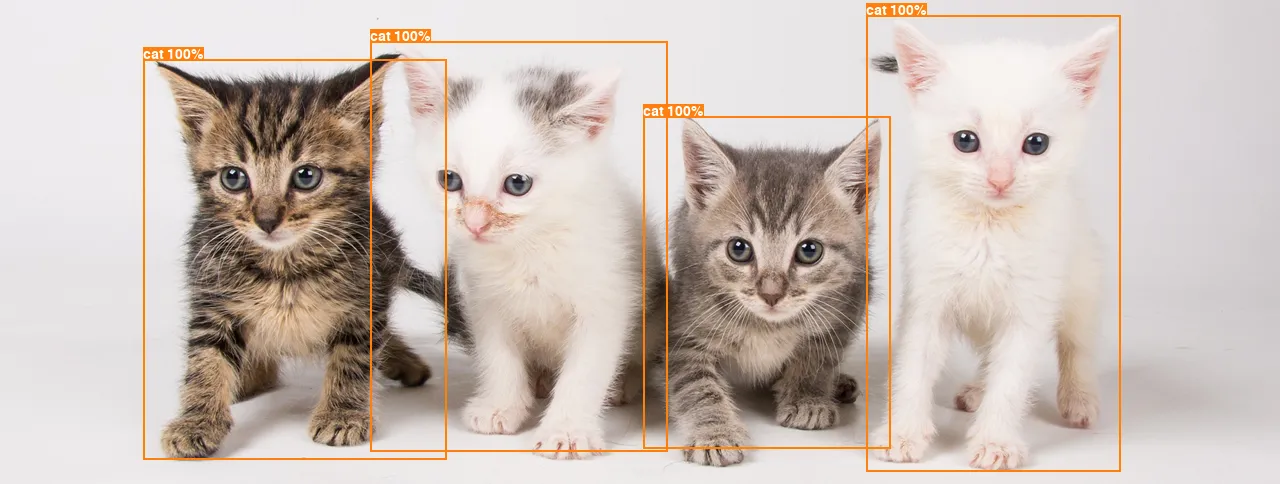

class,confidence,bx,by,bw,bh

cat,1.00,0.78,0.50,0.20,0.94

cat,1.00,0.23,0.54,0.24,0.83

cat,1.00,0.41,0.51,0.23,0.85

cat,1.00,0.60,0.58,0.19,0.69

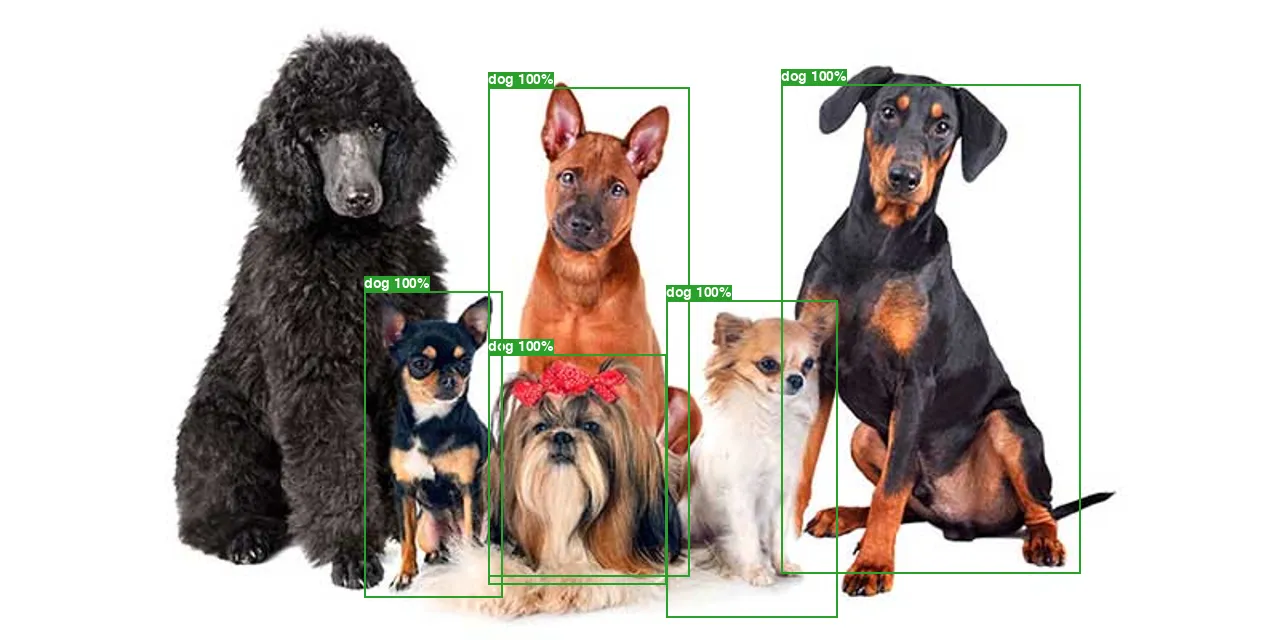

class,confidence,bx,by,bw,bh

dog,1.00,0.73,0.51,0.23,0.76

dog,1.00,0.46,0.52,0.16,0.76

dog,1.00,0.45,0.73,0.14,0.36

dog,1.00,0.34,0.70,0.11,0.48

dog,1.00,0.59,0.72,0.13,0.50

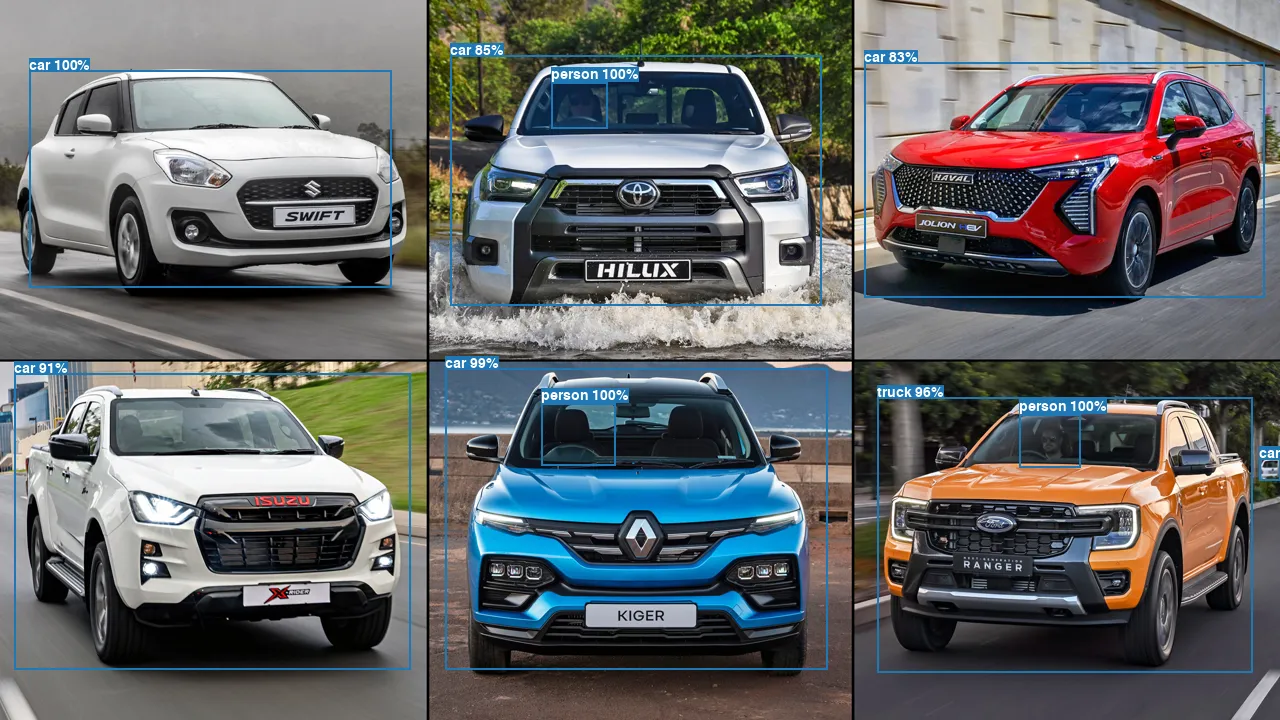

class,confidence,bx,by,bw,bh

person,1.00,0.82,0.61,0.05,0.07

person,1.00,0.45,0.15,0.04,0.06

person,1.00,0.45,0.60,0.06,0.09

car,1.00,0.16,0.25,0.28,0.30

car,0.83,0.83,0.25,0.31,0.33

car,0.91,0.17,0.72,0.31,0.41

car,0.85,0.50,0.25,0.29,0.35

car,0.99,0.50,0.72,0.30,0.42

car,0.97,0.99,0.65,0.02,0.03

truck,0.96,0.83,0.74,0.29,0.38

## Lab 06 - Object Detection using Transfer learning and Pascal VOC 2007 Dataset ##

*ITAI 1378*

*Jaret Sanchez*

**Introduction**

In this lab, I adapted an image classification task to an object detection task. I achieved this by using transfer learning with TensorFlow and the Pascal VOC 2007 dataset. Object detection is not only the classification of objects, but also the use of bounding boxes to determine what they are. In one of our previous labs, we worked with Convolutional Neural Networks (CNN), and in this lab, we are working with a pre-trained CNN called SSD MobileNet V2. Object detection performs classification and localization with the use of bounding boxes that allow us to identify different objects in one image, while image classification only assigns a single label to an image.

To start with the lab, we need to install and import the necessary libraries, continue by loading the Pascal VOC 2007 dataset, and use the pre-trained object detection model (SSD MobileNet V2). The dataset that we use contains images with annotations for object detection, segmentation, and image classification. The VOC 2007 dataset is very large, so we will be using a small subset. The PASCAL VOC 2007 dataset is widely used because it includes a diverse set of object classes and features a wide range of images, making it a great option to train models.

**Implementation**

As I mentioned before, we will be using a pre-trained model for this lab. With the use of TensorFlow Hub repository we will load the SSD MobileNet V2 model. the SSD MobileNet V2 model it provides us with real-time object detection. After loading the model and the dataset, we need to set up a detection pipeline. The dataset that we will be using includes 20 object categories (areoplane, bicycle, bird, boat, bottle, etc), and we will load the model after data preparation because it's more resource-efficient. To display the detected objects with bounding boxes, we will use *detector* (pre-trained model), *detect_objects* (function that detects objects in an image), and *display_detections* (function that detects objects with bounding boxes).

After getting everything set up, I used the *process_uploaded_image* function to upload images from my computer. The images I chose included cats, horses, cars, dogs, and a boat. I tried to use a variety of images to see the different results. Object detection models need to have classification accuracy and localization accuracy, meaning that our model needs to correctly identify the class and accurately draw the bounding box around the object. In this lab, we are focusing on understanding the concepts and not accuracy, and that's the reason our results are not perfect, but the key concepts are clear throughout the exercise. To measure location accuracy, we need to use Intersectional over Union (IoU) metric to see how much two bounding boxes overlap. The IoU threshold in our exercise was set to 0.5, so to get a "true positive" the predicted box and the ground truth box need to overlap at least 50%.


**Reflection**

As mentioned before, the lab is focused on concept understanding and not accuracy. The different outputs we can encounter in a typical object detection model include true positives (both class and bounding box are correct), false positives (objects are misclassified or below the threshold), and false negatives (the objects are missed entirely by the model). The precision of the model is determined by the proportion of positive detections that are correct, and the recall of the model is determined by the proportion of positive objects the model detected. The model's threshold is a factor that directly affects the output of our exercise. If the threshold is lower, we will detect more objects but get a higher number of false positives, and on the other hand, if we raise the threshold, we will improve accuracy but miss smaller objects.

Some of the aspects that I observed while working in this lab were how the model worked better when the objects were centered and clearly visible. Even the online object detector that I used to compare outputs with the lab showed difficulty recognizing smaller objects, objects that were blocked by another one, and confused a shadow with a person. The dataset diversity and quality are crucial for the model to perform accurately.

The interactive activity at the end of the lab, where I was able to upload my own image, was a fun exercise. I did use different images to test the model. At the beginning, I used images with a single object in them, like an image with only a cat or dog, and after that, I decided to upload images with multiple objects, like an image with multiple cars or horses. Uploading my own images shows me how the model works with unseen data and tests the model's generalization capabilities.
  
**Conclusion**

The lab gave me an understanding of the core concepts of object detection with the use of a pre-trained model and a dataset with annotations. The use of transfer learning allows us to use a pre-trained model that we can adapt and use with the presented exercise, and the VOC 2007 dataset allows us to have access to a collection of images annotated with bounding boxes and 20 class labels. I also learned about the importance of threshold adjustment; if the threshold increases, the model will become stricter, lowering the recall, and if the threshold decreases, the model's recall will increase, but precision will be affected.

Overall, working in this lab was a fun activity that helped me grasp better object detection. I really enjoyed the interactive part of the lab, and using different images to work with the model. When working with a pre-trained model comes with its limitations, I think it's a great option for us students to become familiar with this type of work. Using an online object detector model was also fun. I was able to see how two different models with the same purpose show me different outputs.

**References**

- Google. (2023). TensorFlow Object Detection API. TensorFlow. https://www.tensorflow.org/hub/tutorials/tf2_object_detection

- Everingham, M., Van Gool, L., Williams, C. K. I., Winn, J., & Zisserman, A. (2007). The PASCAL Visual Object Classes (VOC) Challenge 2007 (VOC2007). University of Oxford. http://host.robots.ox.ac.uk/pascal/VOC/voc2007/

- Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 4510–4520.